In [135]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%config InlineBackend.figure_format='svg'

In [136]:
def diagonal_mat(shape: tuple[int, int], s: np.ndarray) -> np.ndarray:
    """
    将s序列转化成m*n大小的对角矩阵

    Args:
        shape: 矩阵的形状
        s: 对角线上的元素
    Returns:
        v: 对角矩阵
    """
    assert shape[0] == shape[1] == len(s)

    v = np.zeros(shape)
    for i in range(len(s)):
        v[i, i] = s[i]
    return v


def add_mat(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    不同大小的矩阵相加，默认加在左上角的部分进行相加

    Args:
        a: 矩阵 a
        b: 矩阵 b
    Returns:
        c: 相加后的矩阵
    """
    (ma, na) = a.shape
    (mb, nb) = b.shape
    c = np.zeros((max(ma, mb), max(na, nb)))

    # 使用 numpy 的切片操作加速计算
    c[:ma, :na] = a
    c[:mb, :nb] += b

    return c


def extract_mat(a:np.ndarray, shape: tuple[int, int]) -> np.ndarray:
    """
    截取矩阵 a 中左上角 shape[0]*shape[1] 的部分

    Args:
        a: 矩阵 a
        shape: 截取的形状
    Returns:
        截取后的矩阵
    """
    assert shape[0] <= a.shape[0] and shape[1] <= a.shape[1]

    return a[: shape[0], : shape[1]]


创建类 `SVG_Key` 用于保存水印的密钥

In [137]:
class SVG_Key:
    """
    保存 svd 生成的密钥
    """
    def __init__(
        self,
        U1: np.ndarray,
        S: np.ndarray,
        V1t: np.ndarray,
        watermk_shape: tuple[int, int],
    ):
        self.U1 = U1
        self.S = S
        self.V1t = V1t
        self.watermk_shape = watermk_shape

In [138]:
def encoding_watermark(
    A: np.ndarray, W: np.ndarray, alpha: float
) -> tuple[np.ndarray, SVG_Key]:
    """
    对于图片 A 添加水印 W, alpha 为水印强度

    Args:
        A: 原图矩阵
        W: 水印矩阵
        alpha: 水印强度
    Returns:
        aw: 添加水印后的图片矩阵
        key: 用于提取水印的密钥
    """
    U, s_array, Vt = np.linalg.svd(A, full_matrices=True)
    S = diagonal_mat((U.shape[0], Vt.shape[0]), s_array)  # 原s是个向量，转化成对角矩阵

    assert np.allclose(A, U @ S @ Vt)  # 检查 svd 分解是否正确
    assert all(i <= j for i, j in zip(W.shape, S.shape))  # 确保水印矩阵比待嵌入矩阵小

    L = add_mat(S, alpha * W)  # 添加水印后的矩阵
    U1, S1, V1t = np.linalg.svd(L)  # 对添加水印后的矩阵进行 svd 分解
    S1 = diagonal_mat((U1.shape[0], V1t.shape[0]), S1)  # 原 s 是个向量，转化成对角矩阵
    aw = U @ S1 @ Vt  # 添加水印后新的图片矩阵
    key = SVG_Key(U1, S, V1t, W.shape)  # 用于提取水印的密钥
    return aw, key


def decoding_watermark(A_: np.ndarray, key: SVG_Key) -> np.ndarray:
    """
    从图片 A_ 中提取水印

    Args:
        A_: 带水印的图片矩阵
        key: 用于提取水印的密钥，为 encoding_watermark 函数返回的 key
        alpha: 水印强度
    Returns:
        W_: 提取出来的水印矩阵
    """
    U_, S1_, V_T = np.linalg.svd(A_)
    S1_ = diagonal_mat((U_.shape[0], V_T.shape[0]), S1_)  # 原s是个向量，转化成对角矩阵
    D_ = key.U1 @ S1_ @ key.V1t

    W_ = (D_ - key.S) / alpha

    return extract_mat(W_, key.watermk_shape)

使用 `lena512` 进行测试

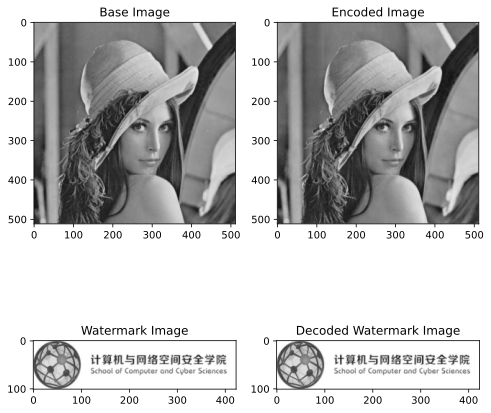

In [139]:
if __name__ == "__main__":
    # init variables
    alpha = 0.2  # 1.0, 0.5, 0.2
    watermark_img_path = "image/gray_logo.jpg"
    base_img_path = "image/lena512.jpg"
    generated_img_path = "image/encoding0_5.jpg"
    decoding_watermark_path = "image/decoding0_5.jpg"

    # 读取图片
    base_img_mat = cv2.imread(base_img_path, cv2.IMREAD_GRAYSCALE)
    watermark_img_mat = cv2.imread(watermark_img_path, cv2.IMREAD_GRAYSCALE)

    # 生成水印加密的图片
    aw, key = encoding_watermark(base_img_mat, watermark_img_mat, alpha)

    # 中间可以对aw进行一些操作，比如加上高斯噪声

    # 解码得到水印图片
    decoding_watermark_mat = decoding_watermark(aw, key)

    # 显示图片
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].imshow(base_img_mat, cmap="gray")
    axs[0, 0].set_title("Base Image")
    axs[0, 1].imshow(aw, cmap="gray")
    axs[0, 1].set_title("Encoded Image")
    axs[1, 0].imshow(watermark_img_mat, cmap="gray")
    axs[1, 0].set_title("Watermark Image")
    axs[1, 1].imshow(decoding_watermark_mat, cmap="gray")
    axs[1, 1].set_title("Decoded Watermark Image")
    plt.show()
    


## 透明性评估

使用 `PSNR` 和 `SSIM` 评估透明性

### PSNR

In [140]:
def psnr(img1: np.ndarray, img2: np.ndarray) -> float:
    """
    计算两张图片的 PSNR 值

    Args:
        img1: 图片 1
        img2: 图片 2
    Returns:
        PSNR 值
    """
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * np.log10(255.0 / np.sqrt(mse))

# 计算 base_img_mat 和 aw 的 PSNR 值

print(psnr(base_img_mat, aw))

33.735286132912556


### SSIM

In [141]:
def ssim(img1: np.ndarray, img2: np.ndarray) -> float:
    """
    计算两张图片的 SSIM 值

    Args:
        img1: 图片 1
        img2: 图片 2
    Returns:
        SSIM 值
    """
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    mu1 = cv2.GaussianBlur(img1, (11, 11), 1.5)
    mu2 = cv2.GaussianBlur(img2, (11, 11), 1.5)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = cv2.GaussianBlur(img1 ** 2, (11, 11), 1.5) - mu1_sq
    sigma2_sq = cv2.GaussianBlur(img2 ** 2, (11, 11), 1.5) - mu2_sq
    sigma12 = cv2.GaussianBlur(img1 * img2, (11, 11), 1.5) - mu1_mu2

    ssim_num = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2))
    ssim_den = ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim_val = ssim_num / ssim_den

    return np.mean(ssim_val)

# 计算 base_img_mat 和 aw 的 SSIM 值
print(ssim(base_img_mat, aw))


1.6653473523069786


## 鲁棒性评估

### 添加高斯噪声

这里尝试添加均值为 0，方差为 10 的高斯噪声

32.38579937968154


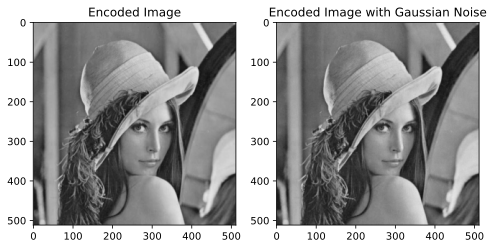

In [142]:
# 添加高斯噪声
mean = 0
variance = 10
sigma = np.sqrt(variance)
noise = np.zeros_like(aw)
cv2.randn(noise, mean, sigma)
aw_noisy = aw + noise

# 计算 base_img_mat 和 aw_noisy 的 PSNR 值
print(psnr(base_img_mat, aw_noisy))

# 显示图片 aw 和 aw_noisy
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(aw, cmap="gray")
axs[0].set_title("Encoded Image")
axs[1].imshow(aw_noisy, cmap="gray")
axs[1].set_title("Encoded Image with Gaussian Noise")
plt.show()


尝试提取出嵌入的水印

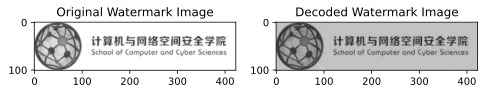

In [143]:
decoding_watermark_mat = decoding_watermark(aw_noisy, key)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(watermark_img_mat, cmap="gray")
axs[0].set_title("Original Watermark Image")
axs[1].imshow(decoding_watermark_mat, cmap="gray")
axs[1].set_title("Decoded Watermark Image")
plt.show()

## 旋转

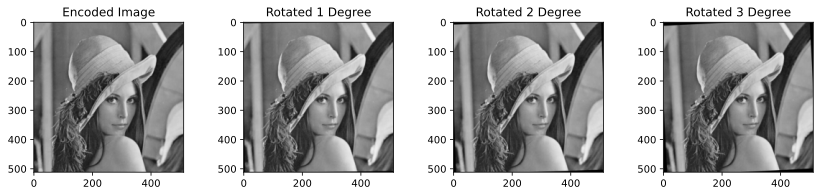

In [144]:
# 旋转
rotation_angle = 3  # 最大旋转度数
aw_rotated_list = []
rows, cols = aw.shape

for i in range(1, rotation_angle + 1):
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), i, 1)
    aw_rotated = cv2.warpAffine(aw, M, (cols, rows))
    aw_rotated_list.append(aw_rotated)

# 显示图片 aw, aw_rotated 和 aw_cropped
fig, axs = plt.subplots(1, 1 + rotation_angle, figsize=(14, 4))
axs[0].imshow(aw, cmap="gray")
axs[0].set_title("Encoded Image")
for i, rotated_img in enumerate(aw_rotated_list):
    axs[i + 1].imshow(rotated_img, cmap="gray")
    axs[i + 1].set_title(f"Rotated {i+1} Degree")

plt.subplots_adjust(wspace=0.4)
plt.show()

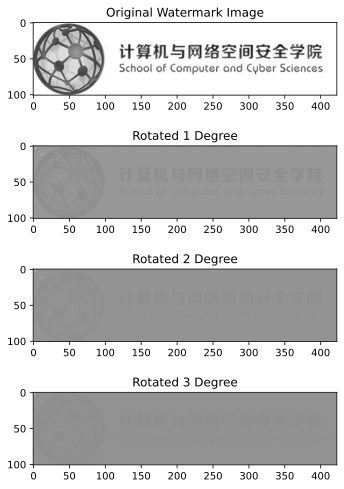

In [145]:
# 显示解码后的水印图像
fig, axs = plt.subplots(1 + rotation_angle, 1, figsize=(10, 8))
axs[0].imshow(watermark_img_mat, cmap="gray")
axs[0].set_title("Original Watermark Image")

for i, rotated_img in enumerate(aw_rotated_list):
    decoding_watermark_mat = decoding_watermark(rotated_img, key)
    axs[i + 1].imshow(decoding_watermark_mat, cmap="gray")
    axs[i + 1].set_title(f"Rotated {i+1} Degree")

plt.subplots_adjust(hspace=0.7)
plt.show()

plt.show()

## 水印容量评估

这里尝试在 `512*512` 的图像上嵌入大小同为 `512*512` 的水印

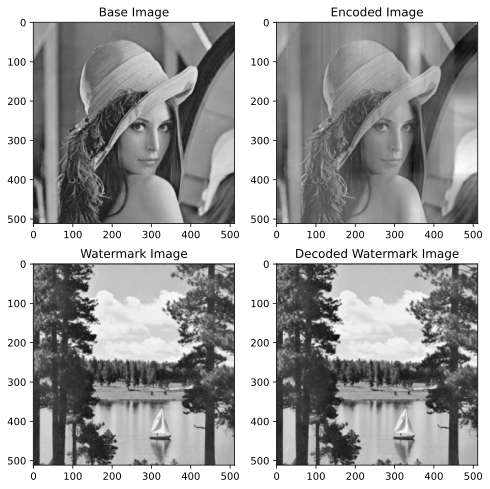

PSNR: 14.433651231149105


In [146]:
def test_insert_watermark(base_img_path: str, watermark_img_path: str, alpha: float):
    """
    测试在 base_img_path 中插入 watermark_img_path 的水印

    Args:
        base_img_path: 原图片路径
        watermark_img_path: 水印图片路径
        alpha: 水印强度
    """

    # 读取图片
    base_img_mat = cv2.imread(base_img_path, cv2.IMREAD_GRAYSCALE)
    watermark_img_mat = cv2.imread(watermark_img_path, cv2.IMREAD_GRAYSCALE)

    # 生成水印加密的图片
    aw, key = encoding_watermark(base_img_mat, watermark_img_mat, alpha)

    # 中间可以对aw进行一些操作，比如加上高斯噪声

    # 解码得到水印图片
    decoding_watermark_mat = decoding_watermark(aw, key)

    # 显示图片
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].imshow(base_img_mat, cmap="gray")
    axs[0, 0].set_title("Base Image")
    axs[0, 1].imshow(aw, cmap="gray")
    axs[0, 1].set_title("Encoded Image")
    axs[1, 0].imshow(watermark_img_mat, cmap="gray")
    axs[1, 0].set_title("Watermark Image")
    axs[1, 1].imshow(decoding_watermark_mat, cmap="gray")
    axs[1, 1].set_title("Decoded Watermark Image")
    plt.show()

    # 计算 PSNR 和 SSIM
    print("PSNR:", psnr(base_img_mat, aw))
    # print("SSIM:", ssim(base_img_mat, aw))

test_insert_watermark("image/lena512.jpg", "Standard_Test_Images/misc_The USC-SIPI Image Database/4.2.06.tiff", 0.5)

可见 `PSNR` 值较小，可以得到结论：`嵌入水印的大小` 与 `对被嵌入图像的影响` 成正比
